# Sparse Deconvolution

Deconvolution seeks to recover the input signal $\mathbf{x}^{\star}$ from 
the available output signal $\mathbf{y}$ of a linear time invariant system   
with finite impulse response (FIR) $\mathbf{h}$.  

In this example the FIR is created using the randomized image method (RIM), 
a popular method used to simulate acoustic impulse responses.


In [1]:
using Pkg, DelimitedFiles, Random, SparseArrays, DSP, Statistics, LinearAlgebra

Pkg.activate("."); Pkg.instantiate();Random.seed!(123) # For reproducibility

h = readdlm("data/h.txt")[:] # load impulse rensponse
Fs = 4000                 # sampling frequency
Nx, Nh = div(Fs,2), length(h)

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


(2000, 1000)

The available signal $\mathbf{y}$ results from 
the convolution between $\mathbf{h}$ and $\mathbf{x}$.

A signal $\mathbf{y}$ can be generated by using a ground truth signal `x_gt` 
and add noise to it to simulate sensor noise.

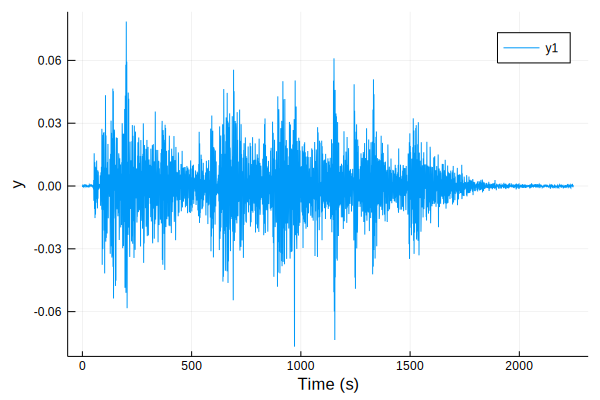

In [2]:
x_gt = Array(sprandn(Nx, 0.05))  # sparse signal ground truth input 

SNR = 15
y0 = conv(x_gt,h[:])                                    # output signal
y = y0+10^(-SNR/10)*sqrt(var(y0))*randn(length(y0));    # add noise

using Plots
t = range(0,step=1/Fs*length(y),length=length(y))
plot(t,y; xlabel="Time (s)", ylabel="y")


A classical way of reconstructing $\mathbf{x}$ is by the least squares procedure:

$$ \mathbf{x}_{ls} =  \underset{\mathbf{x}}{\text{argmin}} \tfrac{1}{2} \| \mathbf{A} \mathbf{x} -\mathbf{y} \|^2,  $$

where $\mathbf{A}$ is the Toeplitz matrix that models convolution. 

The least squares problem has analytic solution and can be solved by means of a pseudo inverse.


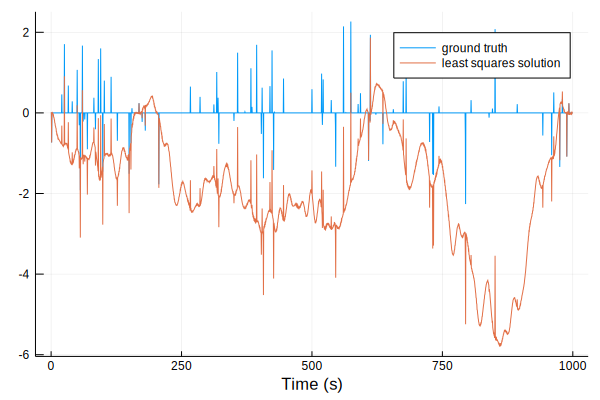

In [3]:
A = hcat([[zeros(i);h;zeros(Nx-1-i)] for i = 0:Nx-1]...) # Full Toeplitz Matrix

x_ls = A\y; # solving using LS

t = range(0,step=1/Fs*length(x_gt),length=length(x_gt))
plot(t, x_gt; label="ground truth", xlabel = "Time (s)")
plot!(t, x_ls; label = "least squares solution")

As the figure above shows, $\mathbf{x}_{ls}$ has many artifacts. 
These are due to the fact that the matrix $\mathbf{A}$ is ill-conditioned and that the recorded signal $\mathbf{y}$ 
is corrupted by noise. 

Better results can be achieved by exploiting the fact that it is known that $\mathbf{x}$ is _sparse_. 

The following optimization problem (LASSO) can be solved using `StructuredOptimization.jl`: 

$$ \mathbf{x}^{\star} =  \underset{ \mathbf{x}  }{\text{argmin}} \tfrac{1}{2} \| \mathbf{A} \mathbf{x} -\mathbf{y} \|^2 + \lambda \| \mathbf{x} \|_1  $$

where an additional term is added to promote sparsity on $\mathbf{x}$.

In [4]:
lambda = 1e-2*norm(A'*y,Inf)

using StructuredOptimization

x = Variable(length(x_gt)) #define variables

@time @minimize ls(A*x-y)+lambda*norm(x,1)


 11.464931 seconds (27.87 M allocations: 1.438 GiB, 7.49% gc time)


((Variable(Float64, (2000,)),), 103)


The matrix $\mathbf{A}$ represents convolution. It is actually possible to avoid its construction and use more efficient algorithms (based on `fft`). This avoids the storage of redundant information and improves the speed of the iterations of the algorithm.


In [5]:
~x .= 0. # initialized variable

@time @minimize ls(conv(x,h)-y)+lambda*norm(x,1)


  2.837781 seconds (4.97 M allocations: 256.775 MiB, 8.51% gc time)


((Variable(Float64, (2000,)),), 103)


Using the sparse prior the signal can be reconstructed more accurately.


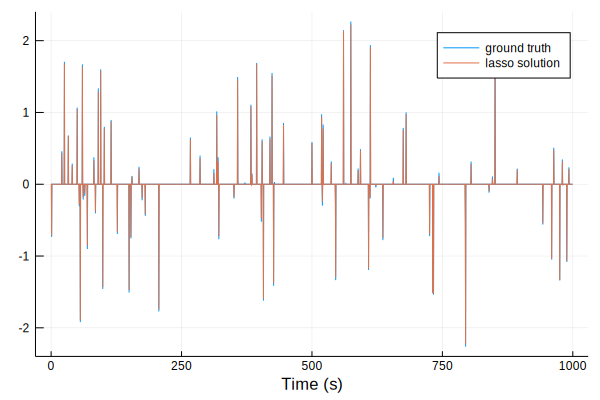

In [6]:
plot(t, x_gt; label = "ground truth", xlabel= "Time (s)")
plot!(t, ~x; label = "lasso solution")